# SARIMA with Exogenous Variables (X)
- The SARIMAX model allows you to include external variables, also termed exogenous variables, to forecast your target.
- Transformations (differencing) are applied only on the target variable, not on the exogenous variables.
- Note: SARIMAX is recommended to forecast multiple timesteps into the future as the exogenous variables must also be forecasted
    - This can magnify the errors on the final forecast. 
    - To avoid that, you must predict only the next timestep using the rolling forecast function.

## Introduction
- The $\text{SARIMAX}$ model further extends the $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model by adding the effect of exogenous variables $X$.
- The SARIMAX model is the **most general model** for forecasting time series. 
    - If no seasonal patterns, it becomes an ARIMAX model. 
    - With no exogenous variables, it is a SARIMA model. 
    - With no seasonality or exogenous variables, it becomes an ARIMA model.
- SARIMA**X** express the present value $y_t$ simply as a SARIMA model to which we add any number $n$ of exogenous variables $X_t$ as below equation:
    - In other words, the SARIMA**X** model simply adds a linear combination of exogenous variables to the SARIMA model.
    
$$y_t =\text{SARIMA}(p,d,q)(P,D,Q)_m + \sum_{i=1}^{n}{\beta_i X_t^i}$$

In [32]:
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from itertools import product
from typing import Union
from tqdm import tqdm
import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

## Exploring the exogenous variables of the US macroeconomics dataset
- There are two ways to work with exogenous variables for time series forecasting. 
    - Method 1: we could train multiple models with various combinations of exogenous variables, and see which model generates the best forecasts. 
    - Method 2: we can simply include all exogenous variables and stick to model selection using the AIC, as we know this yields a good-fitting model that does not overfit.
- All variables in the US macroeconomics dataset

| Variable | Description |
|:--------:|:------------:|
| `realgdp`| Real gross domestic product (the target variable or endogenous variable)|
| `realcons`| Real personal consumption expenditure  |
| `realinv` | Real gross private domestic investment |
| `realgovt` | Real federal consumption expenditure and investment |
| `realdpi` | Real private disposable income |
| `cpi` | Consumer price index for the end of the quarter|
| `m1` | M1 nominal money stock |
| `tbilrate` | Quarterly monthly average of the monthly 3-month treasury bill |
| `unemp` | Unemployment rate |
| `pop` | Total population at the end of the quarter |
| `infl` | Inflation rate |
| `realint` | Real interest rate |

In [41]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data  
macro_econ_data.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
202,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


## Problem with Exogenous variables
- What if you wish to predict two timesteps into the future? 
    - While this is possible with a SARIMA model, the SARIMAX model requires us to forecast the exogenous variables too.
- The only way to avoid that situation is to predict only one timestep into the future and **wait to observe** the exogenous variable before predicting the target for another timestep into the future.
- Summary: There is no clear recommendation to predict only one timestep. 
    - If you determine that your exogenous variable can be accurately predicted, you can recommend forecasting many timesteps into the future. 
    - Otherwise, your recommendation must be to predict one timestep at a time and justify your decision by explaining that errors will accumulate as more predictions are made, meaning that the forecasts will lose accuracy.

## Forecasting with SARIMAX
- In this example, we will use SARIMAX to forecast the real GDP with the exploration of exogenous variables: 'realcons', 'realinv', 'realgovt', 'realdpi', 'cpi'

In [3]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi','cpi']]                                   

In [4]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
check_stationarity(target)

ADF Statistic : 1.75046, p-value: 0.99825
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
KPSS Statistic: 2.06851, p-value: 0.01000
Non-stationary


In [11]:
# apply a transformation and test for stationarity again.
target_diff = target.diff()
check_stationarity(target_diff[1:])

ADF Statistic : -6.30570, p-value: 0.00000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575
KPSS Statistic: 0.39861, p-value: 0.07775
Stationary


- Since the series is stationary after the first difference, so $d = 1$ and we do not need to take a seasonal difference to make the series stationary, so $D = 0$.

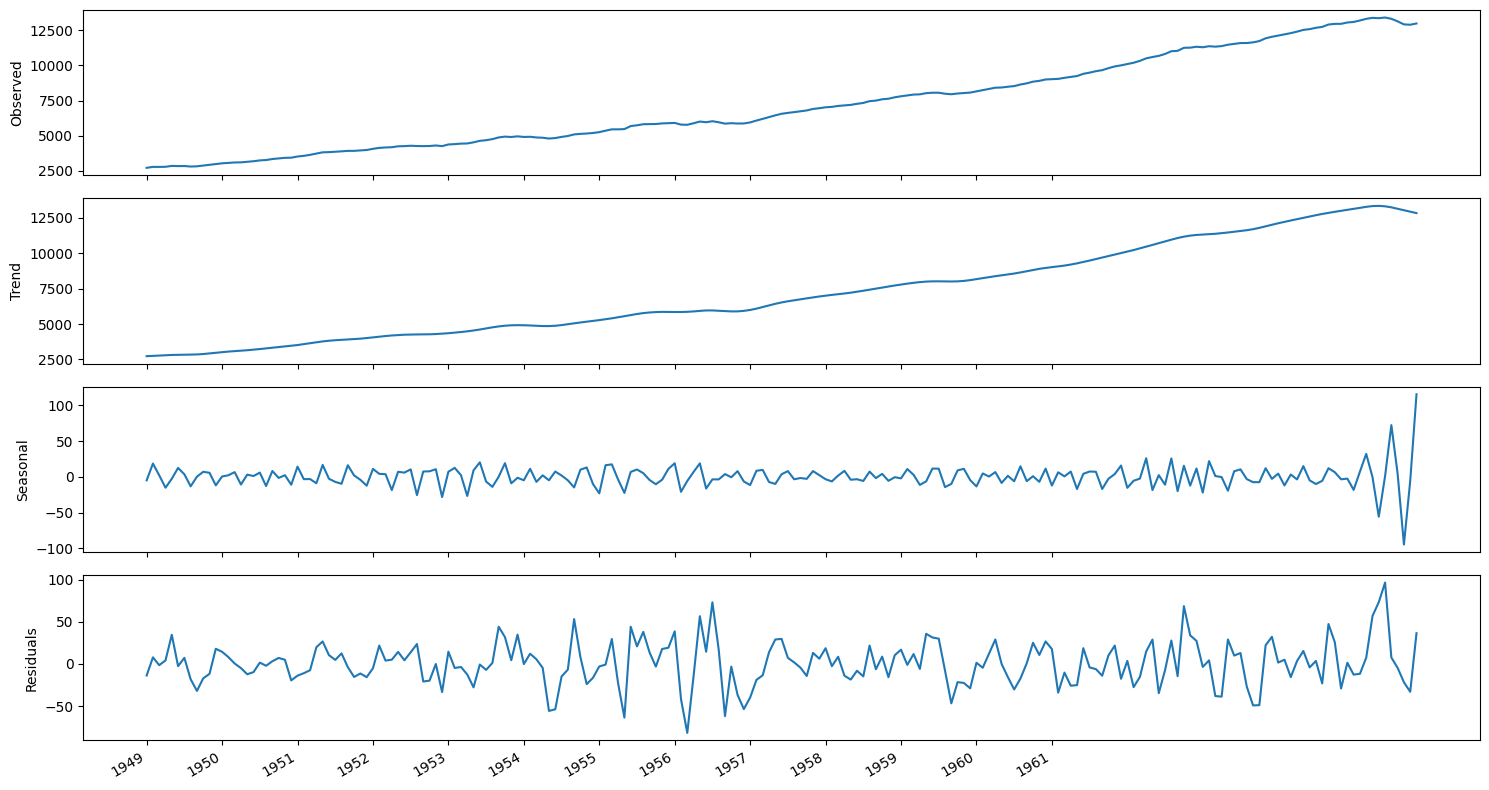

In [43]:
# Decompose the series using the STL function. 
# The period is equal to the frequency m. Since we have quarterly data, the period is 4.
def decompose_ts(df, period=12):
    decomposition = STL(df, period=period).fit()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

    fig.autofmt_xdate()
    plt.tight_layout()

decompose_ts(target, period=4)

- From the time-series decomposition, the series does not contain the seasonality.
- However, we still can try to with SARIMAX model, usually P, Q willl return 0.

In [21]:
def optimize_SARIMAX(endog: Union[pd.Series, list], 
                    exog: Union[pd.Series, list],
                    order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

- Since the data is collected quarterly, $m = 4$ (or $s$ in `SARIMAX` model in `statsmodels`)

In [19]:
# p,q, P,Q and m
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4    # m=4 as the data is collect quarterly  
 
parameters = product(p, q, P, Q)
parameters_list = list(parameters) 

In [ ]:
# Train-test split
# use the first 200 instances of both the target and exogenous variables
target_train = target[:200]
exog_train = exog[:200]
 
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)

In [23]:
result_df.head()

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.821107
1,"(3, 3, 1, 0)",1744.967747
2,"(3, 3, 0, 1)",1744.996645
3,"(2, 2, 0, 0)",1745.488067
4,"(3, 3, 2, 2)",1746.287115


- The function returns the verdict that the $\text{SARIMAX}(3,1,3)(0,0,0)_4$ model is the model with the lowest AIC.
- As expected, the seasonal component of the model has only orders of 0. 

In [24]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.411
Date:                Sat, 25 May 2024   AIC                           1742.821
Time:                        16:11:00   BIC                           1782.341
Sample:                             0   HQIC                          1758.816
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9688      0.045     21.600      0.000       0.881       1.057
realinv        1.0136      0.033     30.816      0.000       0.949       1.078
realgovt       0.7286      0.127      5.741      0.0

- All exogenous variables have a p-value smaller than 0.05, except for `realdpi`, which has a p-value of 0.712. 
    - This means that the coefficient of `realdpi` is not significantly different from 0, and in fact, the **coefficient** of `realdpi` is 0.0096

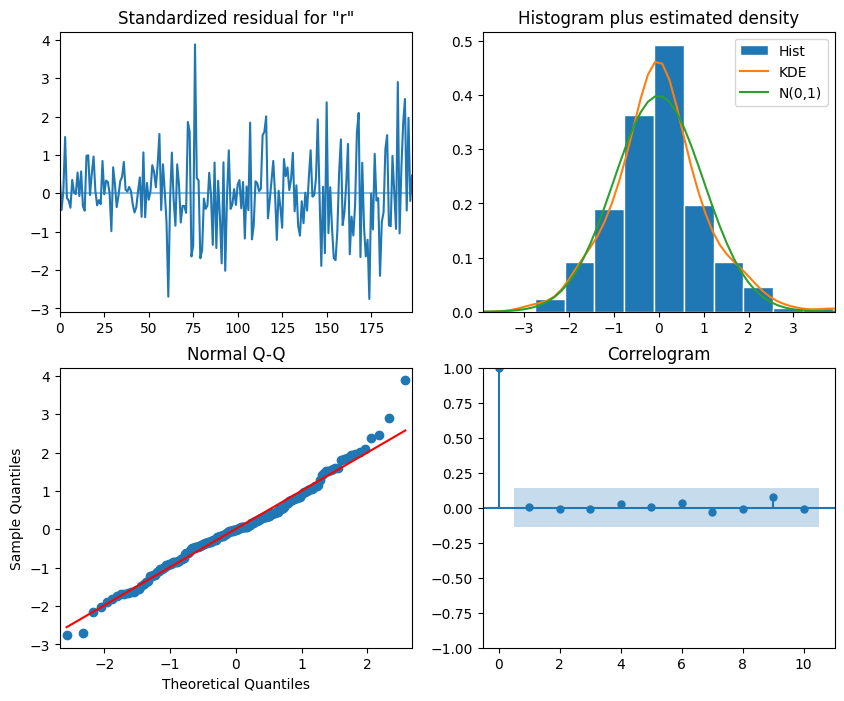

In [25]:
# Residuals Analysis
best_model_fit.plot_diagnostics(figsize=(10,8));

- From the above plots, the distribution of residuals is very close to a normal distribution. 

In [28]:
residuals = best_model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

True

- All the p-values are greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated.

- As mentioned before, the caveat of using a SARIMA**X** model is that it is reasonable to predict **only** the next timestep, as if the exogenous variables might not be available if we predict in a long horizon, so the SARIMAX will have to predict the exogenous variables as well if they are not available, which would lead us to accumulate prediction errors in the final forecast.
- Hence, we will use the rolling forecast function `rolling_forecast`
- Baseline model: last known value

In [29]:
def rolling_forecast(endog: Union[pd.Series, list], 
                     exog: Union[pd.Series, list], 
                     train_len: int, horizon: int, window: int,method: str) -> list:
    
    total_len = train_len + horizon
 
    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [30]:
target_train = target[:196]       
target_test = target[196:]        

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1             
 
pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df = pd.DataFrame({'actual': target_test})
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
 
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.066797
197,13415.266,13366.865,13373.510669
198,13324.600,13415.266,13378.804271
199,13141.920,13324.600,13327.722799
200,12925.410,13141.920,13133.515908
201,12901.504,12925.410,12887.586610
202,12990.341,12901.504,12873.798314


In [31]:
methods = ["pred_last_value", "pred_SARIMAX"]

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=target[190:].index, y=target[190:], name='actual', line = dict(color='royalblue')))

for pred_type in methods: 
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df[pred_type], name=pred_type, line = dict(dash='dash')))

fig.update_layout(
    yaxis_title='Year',
    xaxis_title='GDP',
    title='Prediction on Test Set'
)  
fig.show()

In [38]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

In [39]:
print(mape_last, mape_SARIMAX)

0.736849498653785 0.7025002590225526


- The SARIMAX model is the winning model by only 0.04%